# Project Overview: Heart Disease Prediction

Research Question: Based on a person’s health factors, lifestyle choices and demographics, what is the likely risk of heart disease? 
We'll be testign out Logistic Regression, Decision Trees, Random Forest and Gradient Boosting models in order the find the best prediction model.
Since it will be critical to be able to predict the risk of heart disease with the most accuracy, we'll focus on maximizing the Recall metric (to minimize the number of false negatives), followed by the F1 metric, to avoid too many false positives.


In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
import tensorflow as tf

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import plotly.express as px

# pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.combine import SMOTEENN

# modeling
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
import time

# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

print("All modules loaded")

All modules loaded


## Exploratory Data Analysis (EDA)

In [29]:
# loading the data
url = '/Users/oaxana/Desktop/000_Berkeley/CAPSTONE/heart_2022_with_nans.csv.zip'
df = pd.read_csv(url, sep = ',', na_values = "unknown")

In [30]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [31]:
df.shape

(445132, 40)

In [32]:
df.columns

Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

In [34]:
# checking for duplicates
df.duplicated().sum()

157

In [35]:
# removing duplicates
df = df.drop_duplicates()

In [36]:
# describing numerical features
df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,434053.000000,435913.000000,439527.000000,416470.000000,403044.000000,396316.000000
mean,4.349372,4.384164,7.022909,1.702690,83.074632,28.529907
std,8.689968,8.388541,1.502618,0.107178,21.448241,6.554917
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.130000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,5.000000,8.000000,1.780000,95.250000,31.750000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


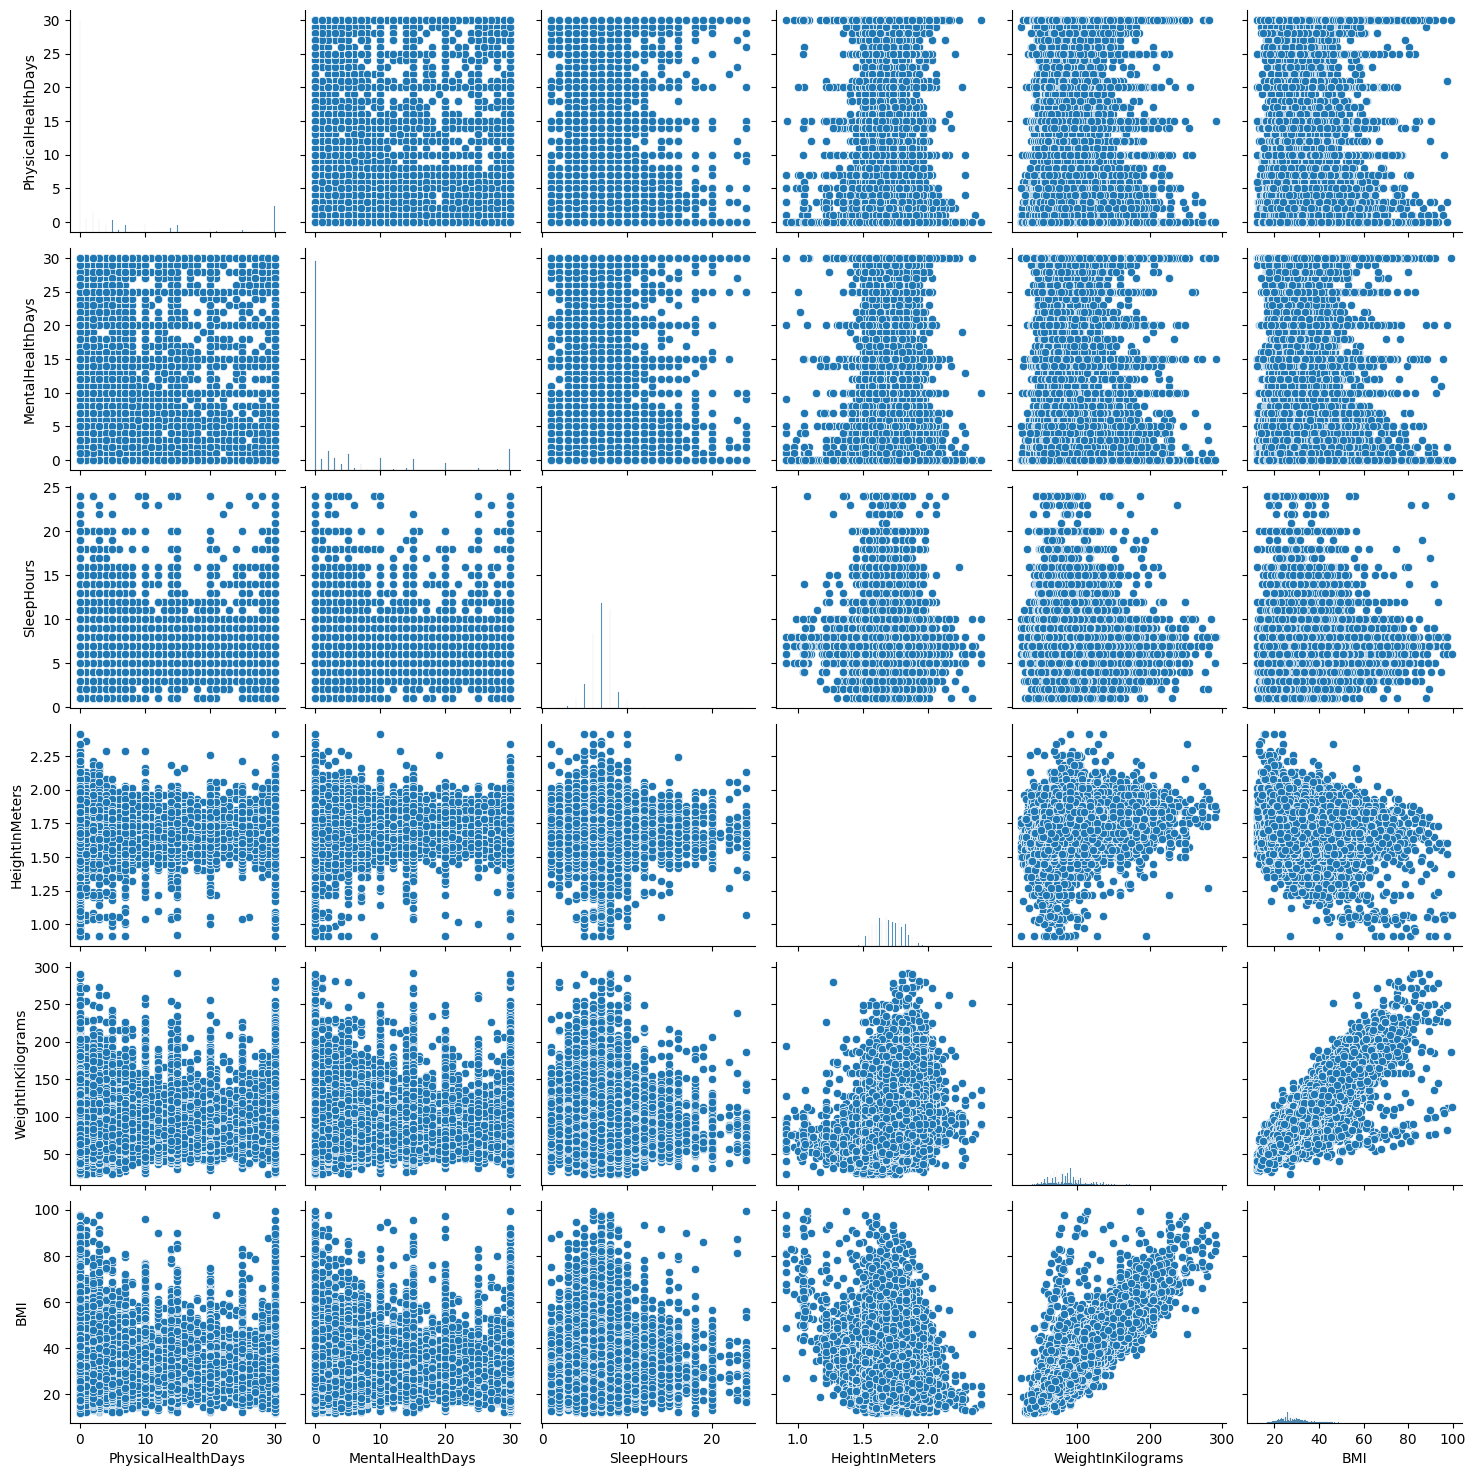

In [37]:
sns.pairplot(df.select_dtypes(include=['number']))
plt.show()

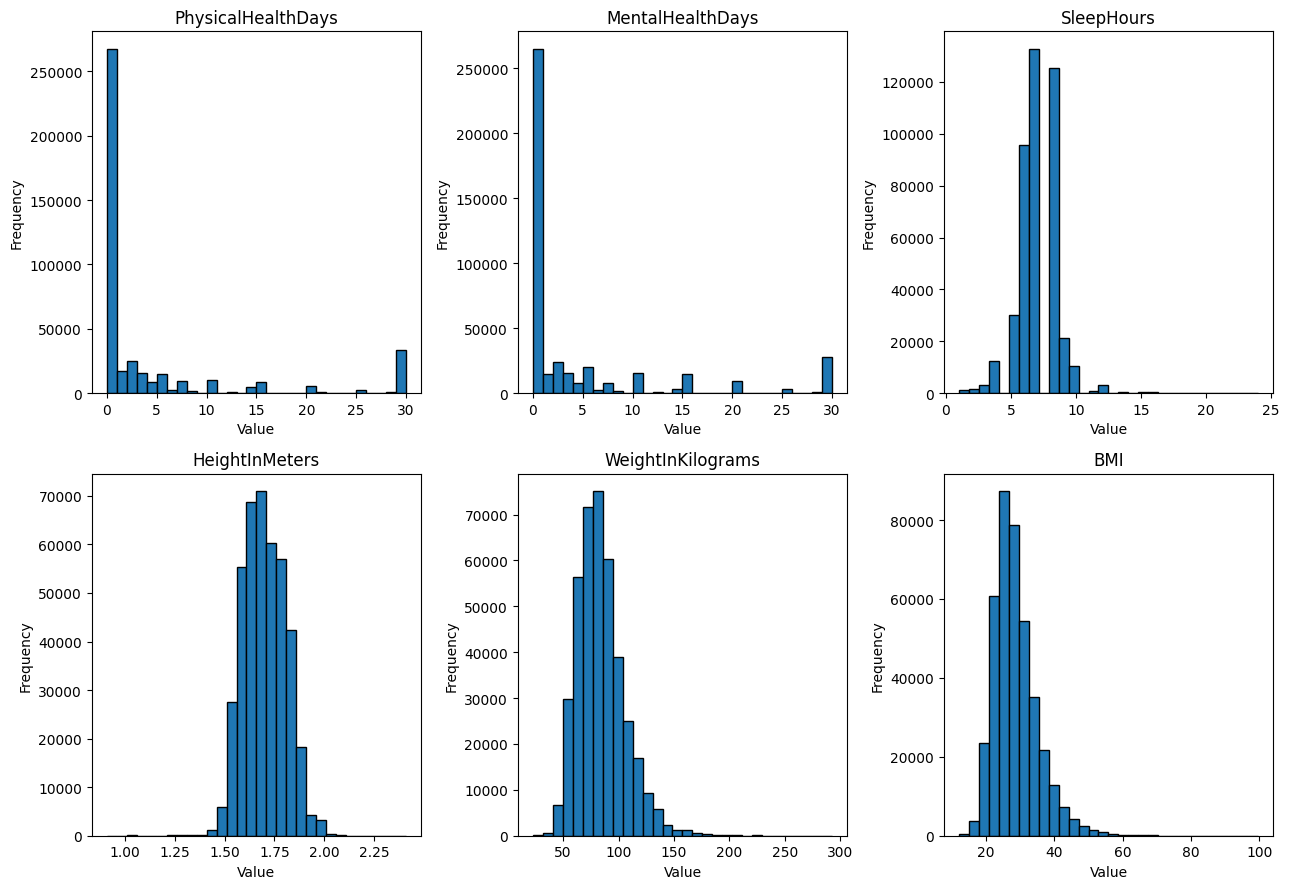

In [38]:
# Define numerical columns for histograms
numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']

# Set up the figure and axes & flatten
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 9))
axes = axes.flatten()

# Plot histograms for each numerical feature
for i, col in enumerate(numerical_columns):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('Value', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Plot the data
plt.tight_layout()
plt.show()


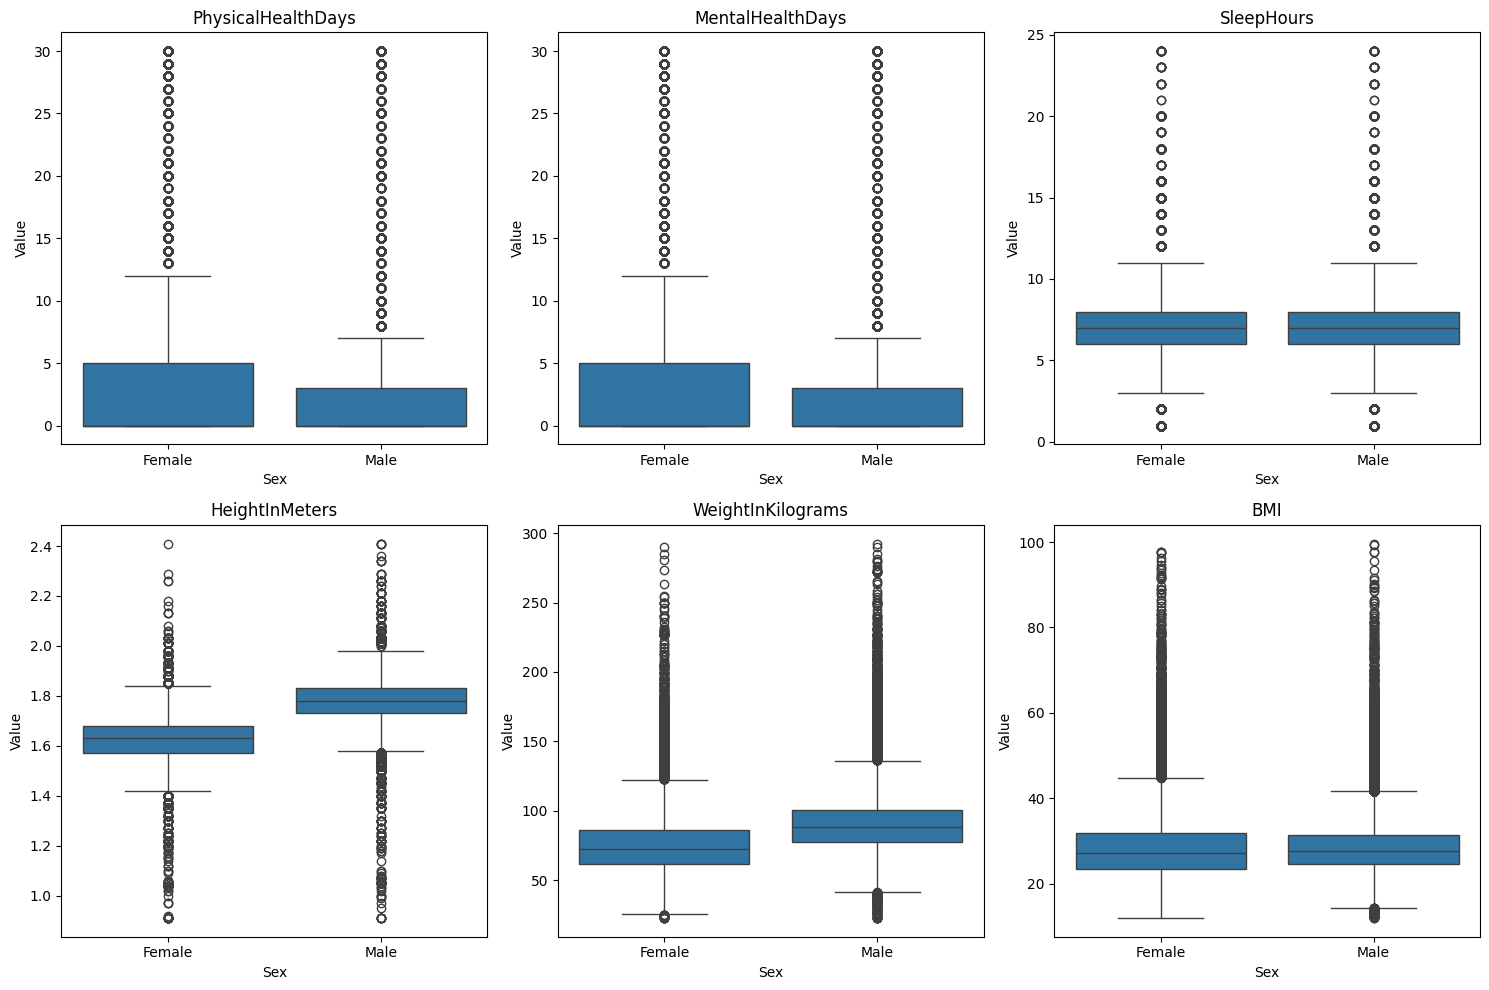

In [39]:
# Define numerical columns for box plots
numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']

# Define the number of rows and columns for subplots
n_cols = 3
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Set up the figure and axes
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot boxplots for each numerical feature by 'Sex'
for i, col in enumerate(numerical_columns):
    sns.boxplot(x='Sex', y=col, data=df, ax=axes[i])
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('Sex', fontsize=10)
    axes[i].set_ylabel('Value', fontsize=10)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Plot the data
plt.tight_layout()
plt.show()

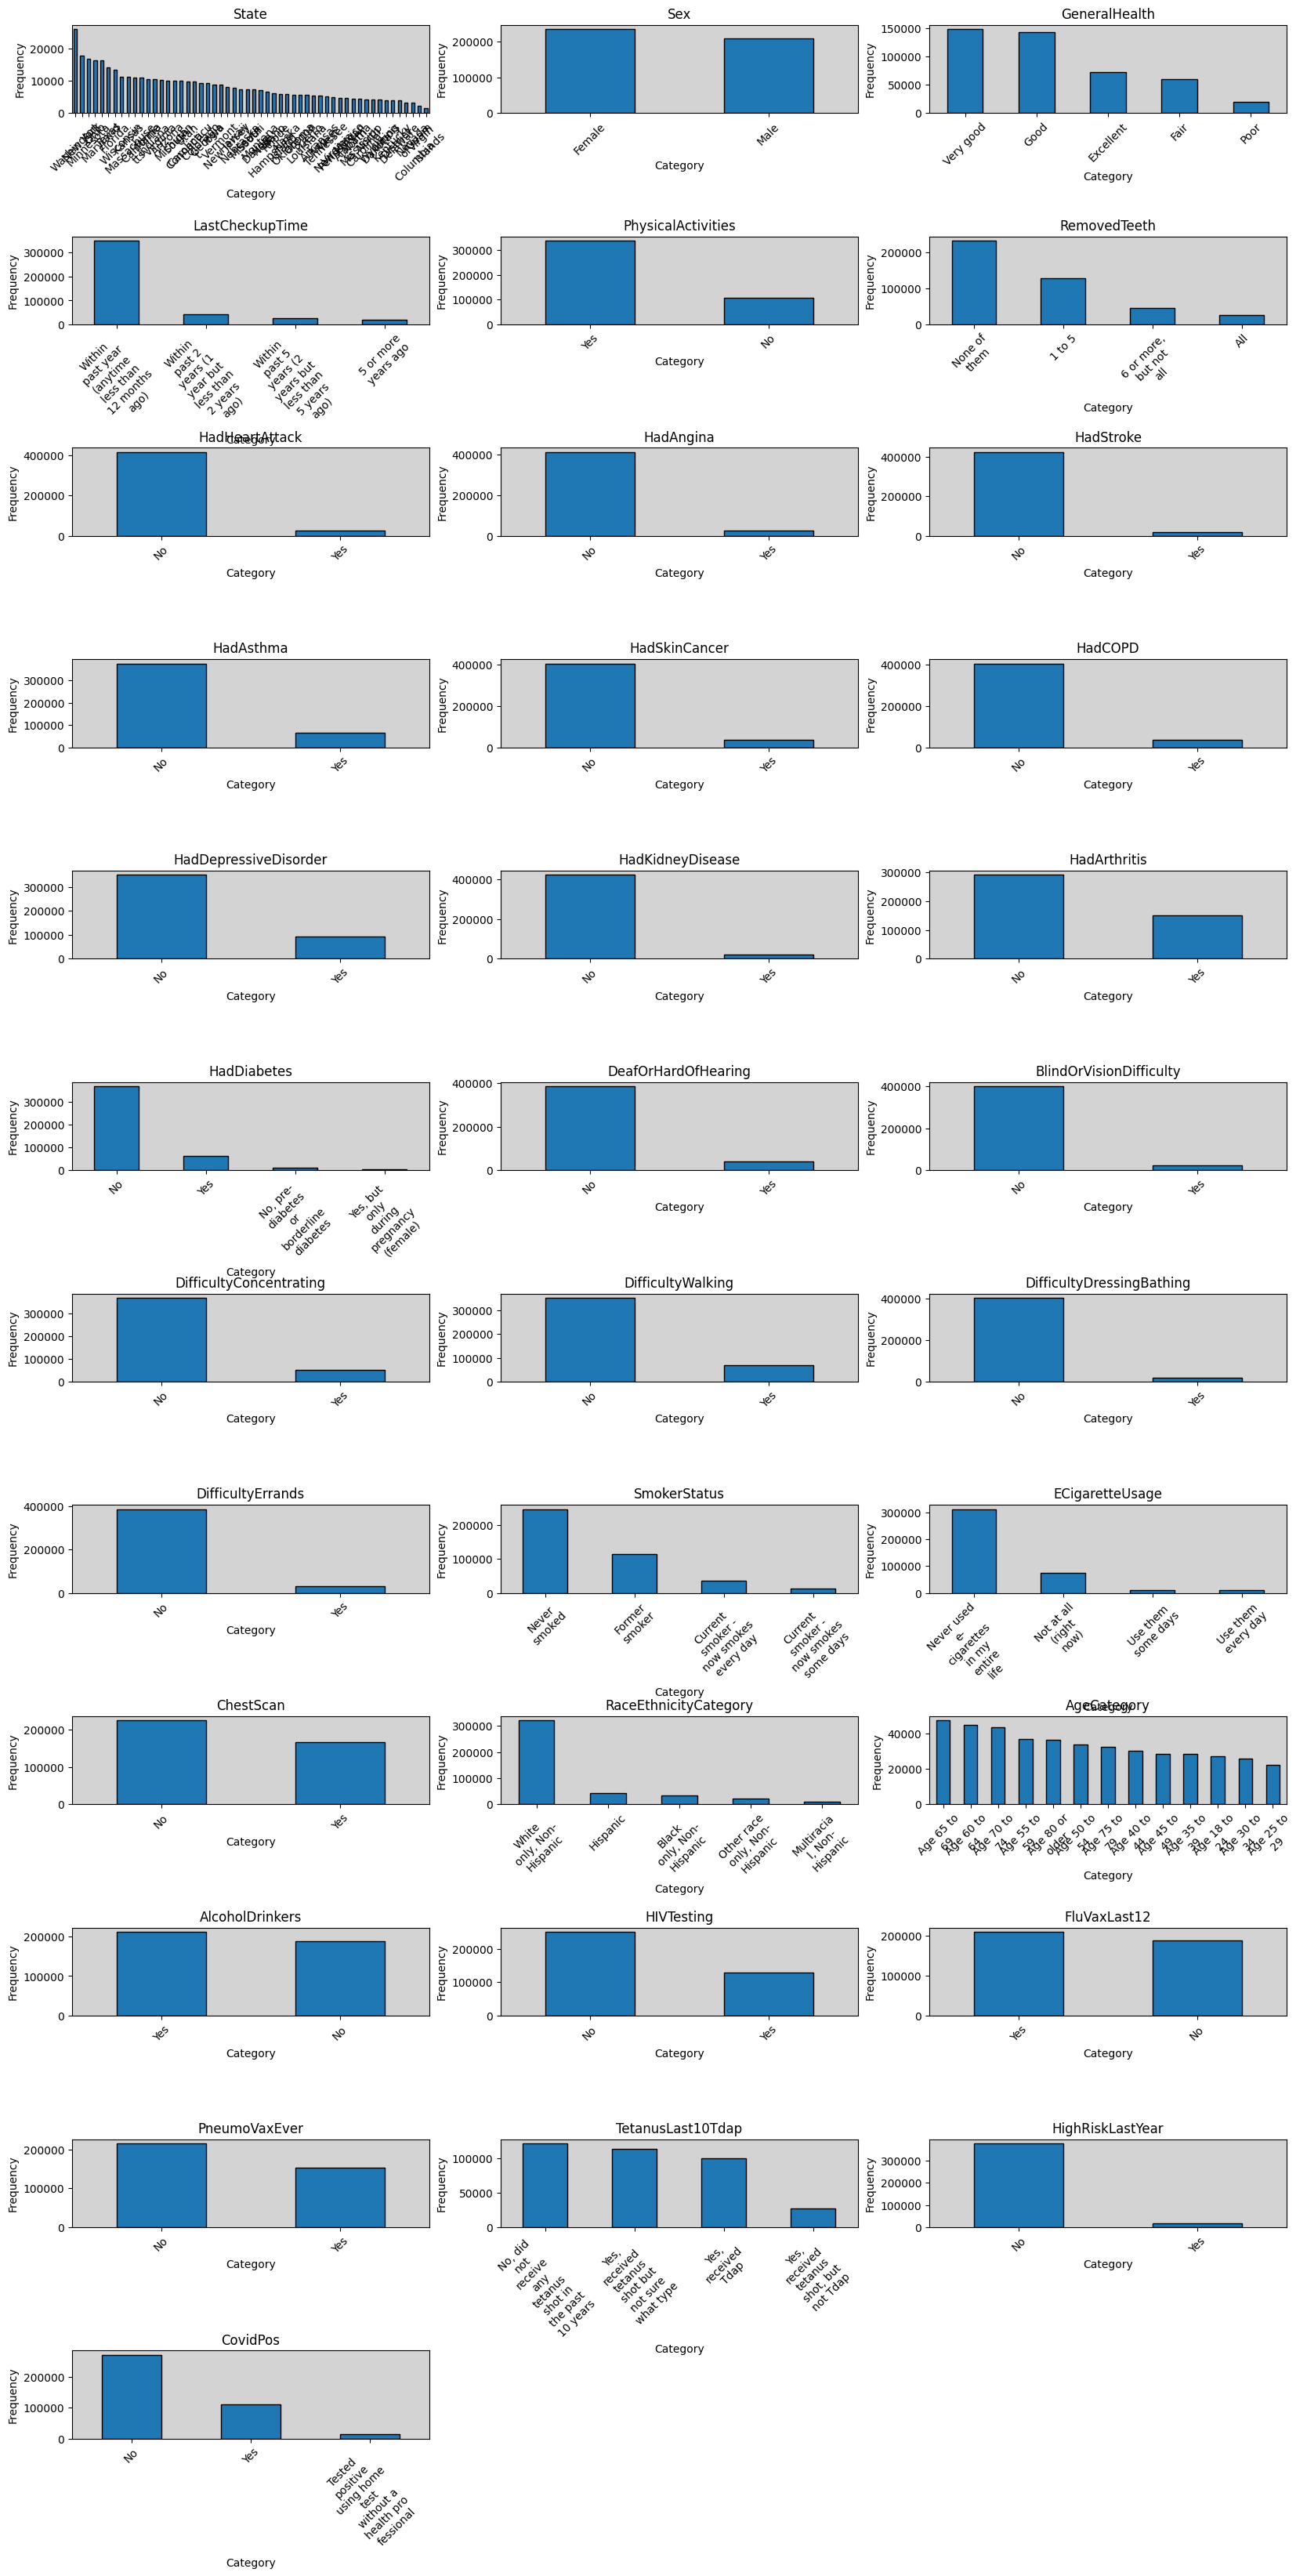

In [40]:
# Define categorical columns for bar plots
categorical_columns = ['State', 'Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 
                       'RemovedTeeth', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 
                       'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 
                       'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 
                       'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 
                       'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 
                       'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 
                       'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 
                       'CovidPos']

# Define the number of rows and columns for subplots
n_cols = 3
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Set up the figure and axes & flatten for easy iteration
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 40))
axes = axes.flatten()

import textwrap #for better visualization of long x-axis labels

# Define a function to wrap text
def wrap_labels(ax, width):
    labels = [textwrap.fill(label.get_text(), width) for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=45, ha='center', fontsize=10)

# Plot bar plots for each categorical feature
for i, col in enumerate(categorical_columns):
    value_counts = df[col].value_counts()
    value_counts.index.name = None  # Ensure no name is set for the index
    value_counts.plot(kind='bar', ax=axes[i], edgecolor='black')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('Category', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].tick_params(axis='y', labelsize=10)  # Rotate x-axis labels
    wrap_labels(axes[i], 10) 
    axes[i].set_facecolor('lightgrey')  # Set background color

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap and add horizontal space
plt.subplots_adjust(wspace=0.2, hspace=1.4)
plt.show()


In [41]:
# Check for NaN values
nan_summary = df.isna().sum()
nan_summary = nan_summary[nan_summary > 0]  # Filter to show only columns with NaN values

# Display the summary of NaN values
print("Summary of NaN values in each column:")
print(nan_summary)


Summary of NaN values in each column:
GeneralHealth                 1193
PhysicalHealthDays           10922
MentalHealthDays              9062
LastCheckupTime               8301
PhysicalActivities            1088
SleepHours                    5448
RemovedTeeth                 11355
HadHeartAttack                3060
HadAngina                     4400
HadStroke                     1552
HadAsthma                     1768
HadSkinCancer                 3138
HadCOPD                       2214
HadDepressiveDisorder         2807
HadKidneyDisease              1921
HadArthritis                  2628
HadDiabetes                   1082
DeafOrHardOfHearing          20502
BlindOrVisionDifficulty      21419
DifficultyConcentrating      24095
DifficultyWalking            23867
DifficultyDressingBathing    23770
DifficultyErrands            25511
SmokerStatus                 35316
ECigaretteUsage              35514
ChestScan                    55900
RaceEthnicityCategory        14048
AgeCategory      

In [42]:
# Drop rows with any NaN values as they are a small portion of the large dataset
df_cleaned = df.dropna()

# Check for remaining NaNs
print(df_cleaned.isna().sum())

State                        0
Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI     

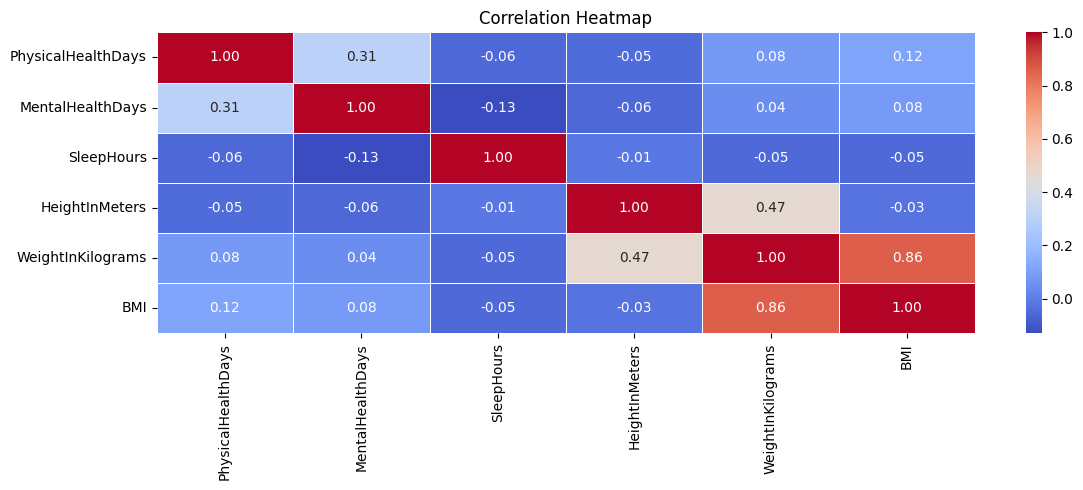

In [43]:
# Select only numerical columns for correlation matrix
numerical_df = df_cleaned.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5)

# Display the heatmap
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [44]:
df_cleaned.sample(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
197294,Minnesota,Male,Good,10.0,5.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.85,92.99,27.05,Yes,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
126550,Kansas,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,None of them,No,...,1.73,86.18,28.89,Yes,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
75393,Florida,Female,Very good,1.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,None of them,No,...,1.57,72.57,29.26,Yes,No,Yes,Yes,"Yes, received Tdap",No,No
84594,Georgia,Male,Poor,30.0,30.0,Within past year (anytime less than 12 months ...,No,4.0,All,Yes,...,1.73,61.23,20.53,Yes,Yes,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
426260,Wisconsin,Male,Good,1.0,2.0,5 or more years ago,Yes,7.0,1 to 5,No,...,1.73,56.70,19.01,Yes,No,No,No,"No, did not receive any tetanus shot in the pa...",Yes,Yes


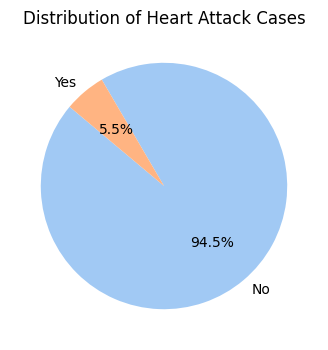

In [45]:
# Count the occurrences of each category in the 'HadHeartAttack' column
heart_attack_counts = df_cleaned['HadHeartAttack'].value_counts()

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(
    heart_attack_counts, 
    labels=heart_attack_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel'), 
    textprops={'fontsize': 10}  # Adjust the fontsize as needed
)

plt.title('Distribution of Heart Attack Cases', fontsize=12)  
plt.show()

## Preprocessing: Scaling and Encoding Data

In [46]:
# List of features to remove: State as it's not relevant, and BMI as it is highly correlated with weight, and most people will know their weight before they know their BMI.
features_to_remove = ['State', 'BMI', 'LastCheckupTime', 'RemovedTeeth', 'TetanusLast10Tdap', 'HIVTesting', 'FluVaxLast12']

# Remove the features
df_cleaned = df_cleaned.drop(columns=features_to_remove)

In [47]:
# Convert 'HadHeartAttack' column to binary
df_cleaned['HadHeartAttack'] = df_cleaned['HadHeartAttack'].map({'Yes': 1, 'No': 0})

In [48]:
# Separate the target variable and features
y = df_cleaned['HadHeartAttack']
X = df_cleaned.drop(columns=['HadHeartAttack'])

In [49]:
# Define numerical features
numerical_features = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters']

# Define ordinal features and their orders
ordinal_features = ['GeneralHealth', 'SmokerStatus', 'ECigaretteUsage', 'AgeCategory', 'HadDiabetes']

ordinal_categories = [
    ['Poor', 'Fair', 'Good', 'Very good', 'Excellent'],  # For 'GeneralHealth'
    ['Current smoker - now smokes every day', 'Current smoker - now smokes some days', 'Former smoker', 'Never smoked'],  # For 'SmokerStatus'
    ['Use them every day', 'Use them some days', 'Not at all (right now)', 'Never used e-cigarettes in my entire life'],  # For 'ECigaretteUsage'
    ['Age 80 or older', 'Age 75 to 79', 'Age 70 to 74', 'Age 65 to 69', 'Age 60 to 64', 
     'Age 55 to 59', 'Age 50 to 54', 'Age 45 to 49', 'Age 40 to 44', 'Age 35 to 39', 
     'Age 30 to 34', 'Age 25 to 29', 'Age 18 to 24'],  # For 'AgeCategory'
     ['Yes','No, pre-diabetes or borderline diabetes', 'Yes, but only during pregnancy (female)','No'] # For 'HadDiabetes'
]

# Define binary nominal features
binary_nominal_features = [
    'PhysicalActivities', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 
    'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 
    'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 
    'ChestScan', 'AlcoholDrinkers', 'PneumoVaxEver', 'HighRiskLastYear'
]

# Define remaining nominal features
remaining_nominal_features = [feature for feature in X.columns if feature not in numerical_features + ordinal_features + binary_nominal_features]




In [50]:
# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_features),
        ('bin', OneHotEncoder(drop='if_binary'), binary_nominal_features),
        ('nom', OneHotEncoder(handle_unknown='ignore'), remaining_nominal_features)
    ])


## Perparing for Modeling
### Key Metrics 

- Primary Metric: Recall – Ensure that you identify as many actual positive cases as possible, minimizing the number of false negatives (FN)
- Secondary Metric: F1 Score – Balance precision and recall to have a more balanced evaluation of model performance.

In [51]:
# Separate the target variable and features
X = df_cleaned.drop(columns=['HadHeartAttack'])
y = df_cleaned['HadHeartAttack']

# Apply the preprocessing pipeline to your real dataset
X_preprocessed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Example: Checking the transformed shape
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')


Training set shape: (196810, 554)
Test set shape: (49203, 554)


### 1. Baseline Model: Dummy Model with Stratified Strategy

In [52]:
# Create a dummy classifier with stratified strategy to compensate for the class imbalance
dummy_clf = DummyClassifier(strategy="stratified") 
dummy_clf.fit(X_train, y_train)

# Make predictions on the test set
y_dummy_pred = dummy_clf.predict(X_test)

# Evaluate the dummy model
dummy_accuracy = accuracy_score(y_test, y_dummy_pred)
dummy_conf_matrix = confusion_matrix(y_test, y_dummy_pred)
dummy_class_report = classification_report(y_test, y_dummy_pred)

print(f'Dummy Model Accuracy: {dummy_accuracy:.4f}')
print('Dummy Model Confusion Matrix:')
print(dummy_conf_matrix)
print('Dummy Model Classification Report:')
print(dummy_class_report)

Dummy Model Accuracy: 0.8955
Dummy Model Confusion Matrix:
[[43908  2650]
 [ 2493   152]]
Dummy Model Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     46558
           1       0.05      0.06      0.06      2645

    accuracy                           0.90     49203
   macro avg       0.50      0.50      0.50     49203
weighted avg       0.90      0.90      0.90     49203



In [53]:
# Evaluate the dummy model
dummy_accuracy = accuracy_score(y_test, y_dummy_pred)
dummy_precision = precision_score(y_test, y_dummy_pred)
dummy_recall = recall_score(y_test, y_dummy_pred)
dummy_f1 = f1_score(y_test, y_dummy_pred)
dummy_roc_auc = roc_auc_score(y_test, y_dummy_pred)
dummy_conf_matrix = confusion_matrix(y_test, y_dummy_pred)

print(f'Dummy Model Accuracy: {dummy_accuracy:.4f}')
print(f'Dummy Model Precision: {dummy_precision:.4f}')
print(f'Dummy Model Recall: {dummy_recall:.4f}')
print(f'Dummy Model F1 Score: {dummy_f1:.4f}')
print(f'Dummy Model ROC AUC Score: {dummy_roc_auc:.4f}')
print('Dummy Model Confusion Matrix:')
print(dummy_conf_matrix)


Dummy Model Accuracy: 0.8955
Dummy Model Precision: 0.0542
Dummy Model Recall: 0.0575
Dummy Model F1 Score: 0.0558
Dummy Model ROC AUC Score: 0.5003
Dummy Model Confusion Matrix:
[[43908  2650]
 [ 2493   152]]


### 2. Logistic Regression, KNN, Decision Tree, Random Forest, XGBoost Models

In [54]:
# Function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f'Training Time: {training_time:.4f} seconds')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('\n')

In [55]:
# Train a logistic regression model with balanced class weights
logreg = LogisticRegression(max_iter=10000, class_weight='balanced')  # class_weight='balanced' helps with imbalance
logreg.fit(X_train, y_train)
y_logreg_pred = logreg.predict(X_test)

# Evaluate Logistic Regression model
evaluate_model(logreg, X_train, y_train, X_test, y_test)

Training Time: 4.7361 seconds
Accuracy: 0.8337
Precision: 0.2105
Recall: 0.7611
F1 Score: 0.3298
ROC AUC Score: 0.7995
Confusion Matrix:
[[39010  7548]
 [  632  2013]]




In [ ]:
# Train and evaluate K-Nearest Neighbors (KNN)
print("K-Nearest Neighbors (KNN):")
knn = KNeighborsClassifier()
evaluate_model(knn, X_train, y_train, X_test, y_test)

In [ ]:
# Train and evaluate Decision Tree
print("Decision Tree:")
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
evaluate_model(dt, X_train, y_train, X_test, y_test)

Decision Tree:
Training Time: 9.6540 seconds
Accuracy: 0.9120
Precision: 0.2484
Recall: 0.3142
F1 Score: 0.2774
ROC AUC Score: 0.6301
Confusion Matrix:
[[44043  2515]
 [ 1814   831]]




In [ ]:
# Train and evaluate Random Forest
print("Random Forest:")
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
evaluate_model(rf, X_train, y_train, X_test, y_test)

In [ ]:
# Calculate the scale_pos_weight
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Train and evaluate XGBoost
print("XGBoost:")
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)


XGBoost:
Training Time: 0.4264 seconds
Accuracy: 0.8315
Precision: 0.2078
Recall: 0.7595
F1 Score: 0.3264
ROC AUC Score: 0.7975
Confusion Matrix:
[[38901  7657]
 [  636  2009]]




### 3. Improving XGBoost

- XGBoost performed the best on the Recall measure above with a score of 0.7244.
- Next we try the SMOTE and Undersampling techniques in hopes to address the class imbalance issue and imrpve our Recall score.
- SMOTE adds more samples from the Positive target (underrepresented class - Having Heart Disease)
- Undersampling removes samples from the Negative target (overrepresented class - NOT having heart disease)

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f'Original dataset shape {Counter(y_train)}')
print(f'Resampled dataset shape {Counter(y_train_resampled)}')

# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Evaluate the model
evaluate_model(xgb_model, X_train_resampled, y_train_resampled, X_test, y_test)


Original dataset shape Counter({0: 186020, 1: 10790})
Resampled dataset shape Counter({0: 186020, 1: 186020})
Training Time: 1.5955 seconds
Accuracy: 0.9490
Precision: 0.5542
Recall: 0.2609
F1 Score: 0.3548
ROC AUC Score: 0.6245
Confusion Matrix:
[[46003   555]
 [ 1955   690]]




In [59]:
# Apply undersampling to the majority class
undersample = RandomUnderSampler(sampling_strategy= 0.3, random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

print(f'Original dataset shape {Counter(y_train)}')
print(f'Resampled dataset shape {Counter(y_train_resampled)}')

# Initialize and train XGBoost with class weights
xgb_model = xgb.XGBClassifier(scale_pos_weight=(len(y_train_resampled) / sum(y_train_resampled)), use_label_encoder=False, eval_metric='logloss', random_state=42)

# Evaluate the model
evaluate_model(xgb_model, X_train_resampled, y_train_resampled, X_test, y_test)

Original dataset shape Counter({0: 186020, 1: 10790})
Resampled dataset shape Counter({0: 35966, 1: 10790})
Training Time: 0.1900 seconds
Accuracy: 0.7837
Precision: 0.1747
Recall: 0.8121
F1 Score: 0.2876
ROC AUC Score: 0.7971
Confusion Matrix:
[[36413 10145]
 [  497  2148]]




In [61]:
# Define new param grid with reasonable ranges
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'scale_pos_weight': [(len(y_train_resampled) / sum(y_train_resampled))]
}

# Define custom scoring function for recall
recall_scorer = make_scorer(recall_score)

# Initialize XGBoost classifier without use_label_encoder
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# Set up GridSearchCV with custom scoring
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring=recall_scorer)

# Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator
best_xgb = grid_search.best_estimator_

# Evaluate the best model
evaluate_model(best_xgb, X_train_resampled, y_train_resampled, X_test, y_test)

# Print the best parameters
print("Best hyperparameters found: ", grid_search.best_params_)


Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=4, n_estimators=100, scale_pos_weight=4.333271547729379, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=4, n_estimators=100, scale_pos_weight=4.333271547729379, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=4, n_estimators=100, scale_pos_weight=4.333271547729379, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=4, n_estimators=100, scale_pos_weight=4.333271547729379, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=4, n_estimators=100, scale_pos_weight=4.333271547729379, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=4, n_estimators=100, scale_pos_weight=4.333271547729379, subsample=0.8; total time=   0.4s
[CV] END colsample

In [62]:
# Initialize and train XGBoost with the best hyperparameters
best_params = {
    'colsample_bytree': 0.7,
    'learning_rate': 0.005,
    'max_depth': 5,
    'n_estimators': 100,
    'scale_pos_weight': 4.333271547729379,
    'subsample': 1.0
}

xgb_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Evaluate the model
evaluate_model(xgb_model, X_train_resampled, y_train_resampled, X_test, y_test)

Training Time: 0.2154 seconds
Accuracy: 0.6292
Precision: 0.1182
Recall: 0.9134
F1 Score: 0.2094
ROC AUC Score: 0.7632
Confusion Matrix:
[[28541 18017]
 [  229  2416]]




### 4. Examining Most Important Features for Prediction

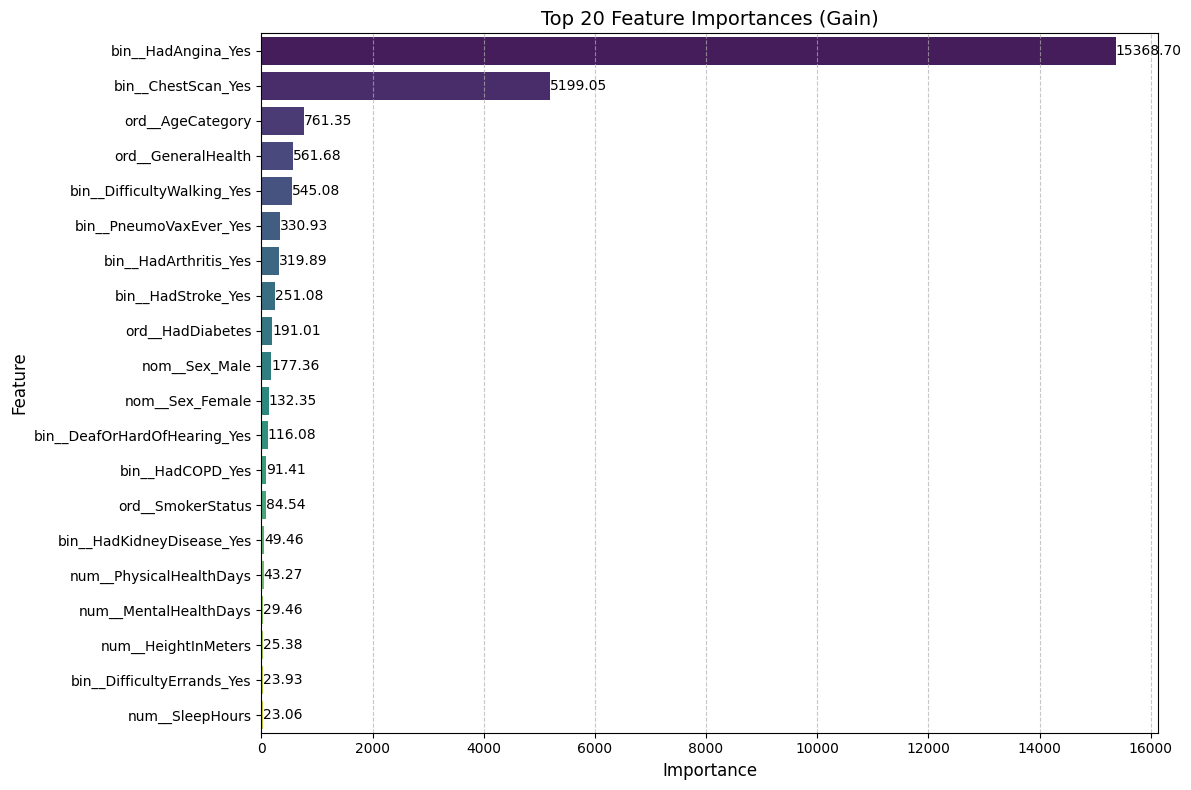

In [63]:
# Get feature importances
feature_importances = xgb_model.get_booster().get_score(importance_type='gain')

# Get the original feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame with feature names
importance_df = pd.DataFrame({
    'Feature': [feature_names[int(f[1:])] for f in feature_importances.keys()],
    'Importance': feature_importances.values()
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top 20 features
top_20_importance_df = importance_df.head(20)

# Plot top 20 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_importance_df, palette='viridis')

# Adding title and labels
plt.title('Top 20 Feature Importances (Gain)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Rotate the y-axis labels for better readability
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add values to the bars
for index, value in enumerate(top_20_importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=10)

# Adjust layout 
plt.tight_layout()
plt.show()
